In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definizione del problema

Il dataset in esame (https://www.kaggle.com/datasets/ananthr1/weather-prediction/data) contiene dati sulle condizioni meteorologiche di Seattle dal 01/01/2012 al 31/12/2015.
L'obiettivo è quello di prevedere le condizioni meteo (es. sole, pioggia, nebbia) di un determinato giorno, si tratta quindi di un problema di classificazione.                                   

In [85]:
dataset = pd.read_csv("seattle-weather.csv")

# Analisi e Manipolazione del dataset

In [86]:
dataset.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


Descrizione delle feature:
- date -> data di riferimento
- precipitation -> valore numerico che indica l'intensità delle precipitazioni in qualunque forma (pioggia, neve, ...)
- temp_max -> temperatura massima giornaliera
- temp_min -> temperaura minima giornaliera
- wind -> velocità del vento
- weather -> etichetta che indica le condizioni meteorologiche della giornata

In questo caso la feature target è "weather", ossia si vuole prevedere le condizioni meteorologiche di una certa giornata.

Almeno inizialmente saranno prese in considerazione tutte le altre feature ai fini della predizione.

Si vuole ora verificare che sia effettivamente presente una riga per ogni data nell'intervallo. 

In [87]:
# Si crea una serie contentente tutte le date presenti del dataset
dates = pd.to_datetime(dataset['date'])

# Si crea l'intervallo completo tra la data minima e massima
date_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')

# Si crea una serie con le date mancanti e si verifica che sia vuota
missing_dates = date_range.difference(dates)
print(missing_dates.empty)


True


Tutte le date nell'intervallo risultano presenti, questo rende il dataset comodamente utilizzabile come serie temporale. Si decide quindi di effettuare un parsing delle date e impostarle come indice del dataset.

In [88]:
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

In [89]:
print(dataset.describe())

print("\n")

nan_rows = dataset.isna().any(axis=1).sum()
print("Numero di righe contenenti valori Nan: " + str(nan_rows))

       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000


Numero di righe contenenti valori Nan: 0


Il Dataset non presenta righe contenenti valori NaN, non è quindi necessario alcun intervento di *fill*.

## Analisi del bilanciamento delle classi

Si vuole ora verificare in che percentuale compaiono le classi della colonna target.

<function matplotlib.pyplot.show(close=None, block=None)>

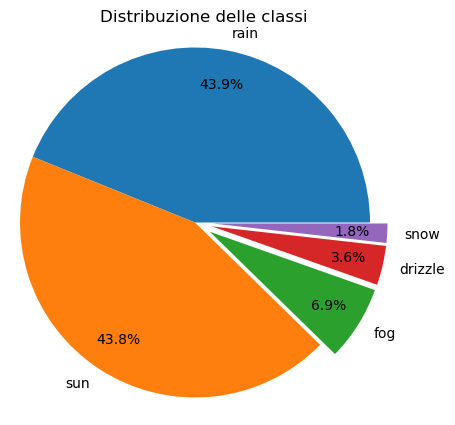

In [90]:
label_counts = dataset['weather'].value_counts()

explode = [0.1 if count / label_counts.sum() < 0.2 else 0 for count in label_counts]

plt.figure(figsize=(5,5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', pctdistance=0.8,
        explode=explode)

plt.title("Distribuzione delle classi")
plt.axis('equal')
plt.show


A causa della natura del dataset le classi risultano ovviamente molto sbilanciate, è tuttavia necessario procedere con cautela nel caso si intendano applicare tecniche di bilanciamento delle classi in quanto potrebbero violare la sequenzialità temporale.

## Analisi della stagionalità

Trattandosi di una serie temporale rappresentante dati meteorologici, risulta opportuno analizzare la stagionalità dei dati.

Per una migliore analisi si aggiungono al dataset due nuove colonne: una rappresentante il mese e una rappresentante il giorno dell'anno. Si aggiunge inoltre una colonna con la temperatura media giornaliera.

In [91]:
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.day_of_year

dataset['temp_mean'] = (dataset['temp_max'] + dataset['temp_min']) / 2

dataset.iloc[26:36, :]

,precipitation,temp_max,temp_min,wind,weather,month,day,temp_mean
date,,,,,,,,
2012-01-27,0.0,6.7,-2.2,1.4,drizzle,1,27,2.25
2012-01-28,0.0,6.7,0.6,2.2,rain,1,28,3.65
2012-01-29,27.7,9.4,3.9,4.5,rain,1,29,6.65
2012-01-30,3.6,8.3,6.1,5.1,rain,1,30,7.20
2012-01-31,1.8,9.4,6.1,3.9,rain,1,31,7.75
2012-02-01,13.5,8.9,3.3,2.7,rain,2,32,6.10
2012-02-02,0.0,8.3,1.7,2.6,sun,2,33,5.00
2012-02-03,0.0,14.4,2.2,5.3,sun,2,34,8.30
2012-02-04,0.0,15.6,5.0,4.3,sun,2,35,10.30


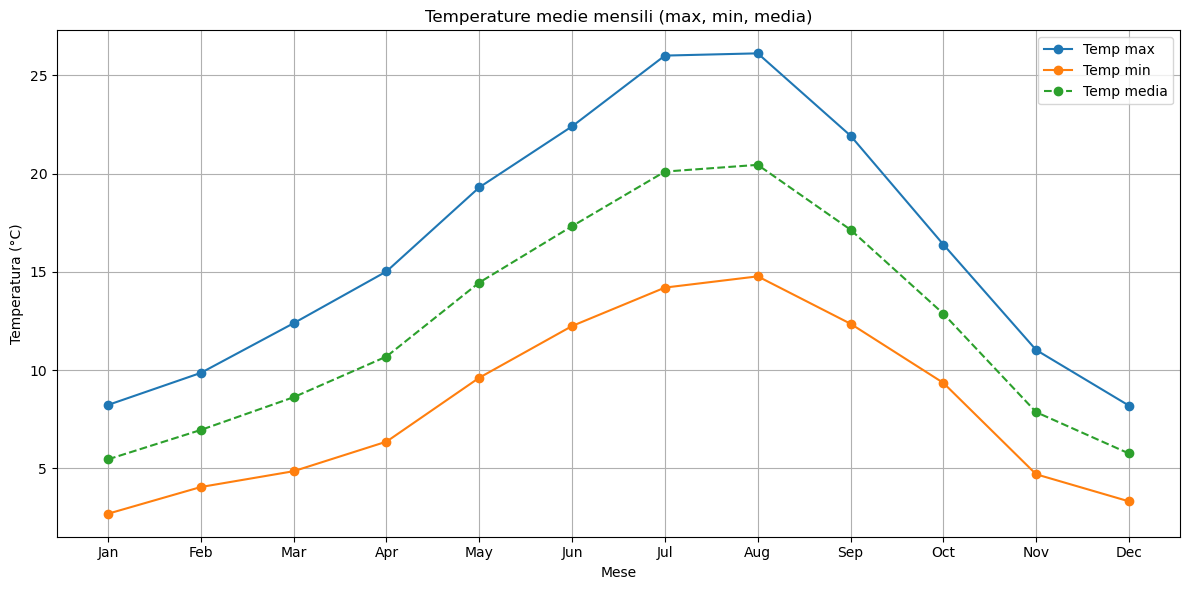

In [92]:
monthly_mean = dataset.groupby('month')[['temp_max', 'temp_min', 'temp_mean']].mean()

month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12,6))
plt.plot(month_name, monthly_mean['temp_max'], marker='o', label='Temp max')
plt.plot(month_name, monthly_mean['temp_min'], marker='o', label='Temp min')
plt.plot(month_name, monthly_mean['temp_mean'], marker='o', label='Temp media', linestyle='--')

plt.title('Temperature medie mensili (max, min, media)')
plt.xlabel('Mese')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

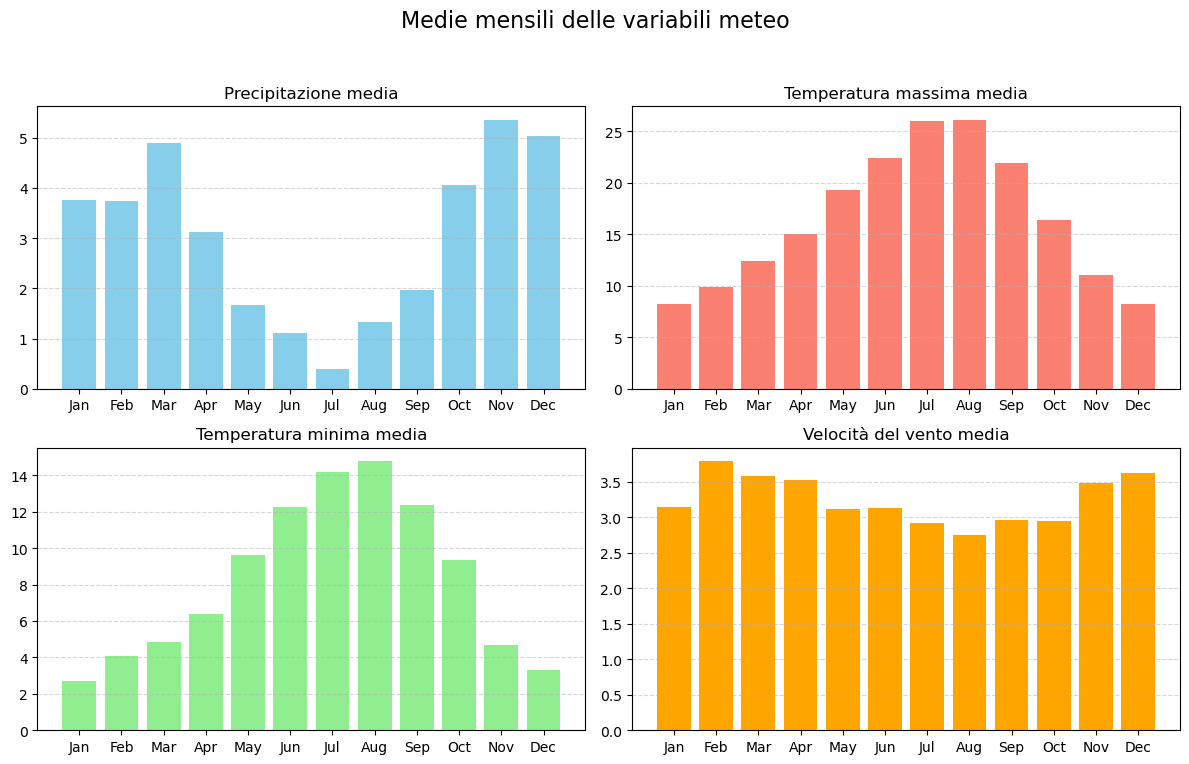

In [93]:
grouped = dataset.groupby('month')[['precipitation', 'temp_max', 'temp_min', 'wind']].mean()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

# Precipitazione media
ax1.bar(grouped.index, grouped['precipitation'], color='skyblue')
ax1.set_title('Precipitazione media')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_name)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Temperaura massima
ax2.bar(grouped.index, grouped['temp_max'], color='salmon')
ax2.set_title('Temperatura massima media')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_name)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Temperatura minima
ax3.bar(grouped.index, grouped['temp_min'], color='lightgreen')
ax3.set_title('Temperatura minima media')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(month_name)
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# Vento
ax4.bar(grouped.index, grouped['wind'], color='orange')
ax4.set_title('Velocità del vento media')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_name)
ax4.grid(axis='y', linestyle='--', alpha=0.5)

fig.suptitle('Medie mensili delle variabili meteo', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

I grafici mostrano ciò che ci si poteva aspettare, ossia che è presente una forte componente di stagionalità nei dati, in particolare per quanto riguarda temperatura e precipitazioni.

## Correlazione tra i dati

Si procede visualizzando un grafico che mostra la correlazione tra le feature numeriche.

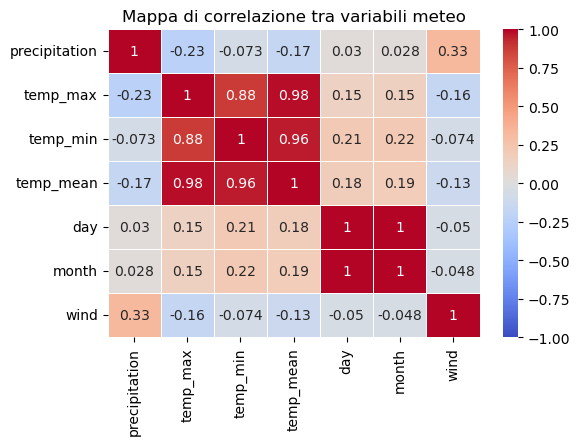

In [94]:
numerical_features = dataset[['precipitation', 'temp_max', 'temp_min', 'temp_mean', 'day', 'month', 'wind',]]

correlations = numerical_features.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Mappa di correlazione tra variabili meteo')
plt.show()

Esattamente come ci si poteva aspettare è presente un forte legame tra temperature massime e minime in quanto in quanto in generale è la temperatura media a variare nei diversi mesi dell'anno. In seguito si deciderà se utilizzare entrambe le feature per la predizione oppure se mantenere soltanto *temp_mean*. Tutte le altre feature non presentano correlazioni significative.

# Feature Engineering

In [95]:
dataset.head()

,precipitation,temp_max,temp_min,wind,weather,month,day,temp_mean
date,,,,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle,1,1,8.90
2012-01-02,10.9,10.6,2.8,4.5,rain,1,2,6.70
2012-01-03,0.8,11.7,7.2,2.3,rain,1,3,9.45
2012-01-04,20.3,12.2,5.6,4.7,rain,1,4,8.90
2012-01-05,1.3,8.9,2.8,6.1,rain,1,5,5.85


Sono già state aggiunte in precedenza le colonne *month*, *day* e *temp_mean* le quali potrebbero di fatto tornare utili per la predizione in quanto *month* e *day* rappresentano informazioni utili per la stagionalità e *temp_mean* può sostituire interamente *temp_max* e *temp_mean* come mostrato nella matrice di correlazione.

## Encoding delle variabili target

Siccome si vuole utilizzare la colonna *weather* come target è necessario prima introurre un encoding per le classi, non è tuttavia possibile utilizzare il One-Hot Encoding in quanto renderebbe le variabili target distribuite su più colonne. Si sceglie quindi di procedere con un semplice *LabelEncoder*.

In [96]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
dataset['weather_encoded'] = encoder.fit_transform(dataset['weather'])

print(dataset[['weather', 'weather_encoded']].head(16))
print("\n")
print("classi encoded: " + str(encoder.classes_))

            weather  weather_encoded
date                                
2012-01-01  drizzle                0
2012-01-02     rain                2
2012-01-03     rain                2
2012-01-04     rain                2
2012-01-05     rain                2
2012-01-06     rain                2
2012-01-07     rain                2
2012-01-08      sun                4
2012-01-09     rain                2
2012-01-10     rain                2
2012-01-11      sun                4
2012-01-12      sun                4
2012-01-13      sun                4
2012-01-14     snow                3
2012-01-15     snow                3
2012-01-16     snow                3


classi encoded: ['drizzle' 'fog' 'rain' 'snow' 'sun']


Siccome si vuole effettuare una predizione della condizione meteorologica del giorno seguente rispetto a cui si possiedono i dati, si introduce una nuova colonna contenente uno shift verso l'alto dei valori interessati.

In [97]:
dataset['next_day_weather_encoded'] = dataset['weather_encoded'].shift(-1)
# La cella NaN così creata sarà eliminata in seguito

## Introduzione di lag features

Siccome si sta lavorando con una serie temporale si decide di introdurre delle *lag features*, nello specifico per quanto riguarda la temperatura media, in quanto la temperatura media di un certo giorno in genere non differisce troppo da quella dei giorni precedenti.
L'utlità di queste *lag features* è per ora soltanto ipotetica, al momento dell'addestramento di un modello saranno i risultati a dimostrarne l'efficacia.

In [98]:
# Si effettua una media mobile negli orizzonti temporali di 3, 7 e 15 giorni

dataset['temp_mean_lag3'] = dataset['temp_mean'].rolling(window=3).mean().shift(1)
dataset['temp_mean_lag7'] = dataset['temp_mean'].rolling(window=7).mean().shift(1)
dataset['temp_mean_lag15'] = dataset['temp_mean'].rolling(window=15).mean().shift(1)

# Lo shift viene applicato per evitare data leakage

print(dataset.head())

            precipitation  temp_max  temp_min  wind  weather  month  day  \
date                                                                       
2012-01-01            0.0      12.8       5.0   4.7  drizzle      1    1   
2012-01-02           10.9      10.6       2.8   4.5     rain      1    2   
2012-01-03            0.8      11.7       7.2   2.3     rain      1    3   
2012-01-04           20.3      12.2       5.6   4.7     rain      1    4   
2012-01-05            1.3       8.9       2.8   6.1     rain      1    5   

            temp_mean  weather_encoded  next_day_weather_encoded  \
date                                                               
2012-01-01       8.90                0                       2.0   
2012-01-02       6.70                2                       2.0   
2012-01-03       9.45                2                       2.0   
2012-01-04       8.90                2                       2.0   
2012-01-05       5.85                2                     

L' introduzione delle *lag features* ha inevitabilmente creato delle celle NaN, si procede pertanto alla loro cancellazione.

In [99]:
weather_df = dataset.dropna()
print(weather_df.head())

            precipitation  temp_max  temp_min  wind weather  month  day  \
date                                                                      
2012-01-16            2.5       1.7      -2.8   5.0    snow      1   16   
2012-01-17            8.1       3.3       0.0   5.6    snow      1   17   
2012-01-18           19.8       0.0      -2.8   5.0    snow      1   18   
2012-01-19           15.2      -1.1      -2.8   1.6    snow      1   19   
2012-01-20           13.5       7.2      -1.1   2.3    snow      1   20   

            temp_mean  weather_encoded  next_day_weather_encoded  \
date                                                               
2012-01-16      -0.55                3                       3.0   
2012-01-17       1.65                3                       3.0   
2012-01-18      -1.40                3                       3.0   
2012-01-19      -1.95                3                       3.0   
2012-01-20       3.05                3                       2.0  

# Funzioni di utilità

In [146]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_true, y_pred, labels=encoder.classes_, normalize=False, title='Matrice di Confusione', cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # gestisce divisioni per 0

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Suddivisione del dataset per l'addestramento

In [140]:
# features = ["temp_mean", "temp_mean_lag3", "temp_mean_lag7", "temp_mean_lag15", "precipitation", "wind", "month", "day"]

features = ["temp_mean", "temp_mean_lag3", "precipitation", "day", "weather_encoded"]

features = ["temp_mean", "temp_mean_lag3", "temp_mean_lag7", "temp_mean_lag15", "precipitation", "wind", "weather_encoded", "day"]

target = "next_day_weather_encoded"
X = weather_df[features]
y = weather_df[target]

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Modelli

## Random Forest

In [142]:
from sklearn.ensemble import RandomForestClassifier

r_forest = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=27)
r_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=27)

In [147]:
r_forest_pred = r_forest.predict(X_test)
print(classification_report(y_test, r_forest_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.25      0.14      0.18         7
         1.0       0.00      0.00      0.00        76
         2.0       0.60      0.71      0.65       220
         3.0       0.00      0.00      0.00         1
         4.0       0.68      0.77      0.72       274

    accuracy                           0.64       578
   macro avg       0.30      0.32      0.31       578
weighted avg       0.55      0.64      0.59       578



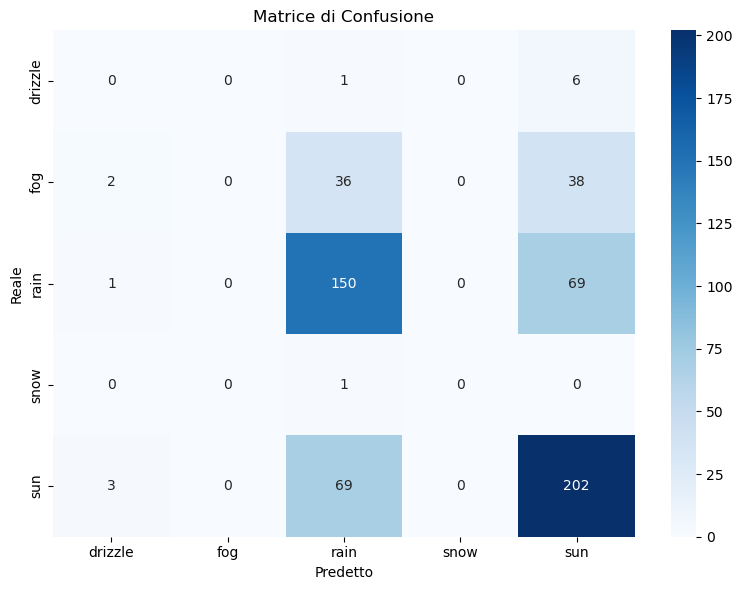

In [135]:
plot_confusion_matrix(y_test.values, r_forest_pred)

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators = 200,
    random_state = 42,
    objective='multi:softprob',
    num_class=len(encoder.classes_),
    eval_metric='mlogloss'
)

xgb.fit(X_train, y_train)

c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:34:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [162]:
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test, xgb_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.00      0.00      0.00        76
         2.0       0.54      0.61      0.57       220
         3.0       0.00      0.00      0.00         1
         4.0       0.60      0.69      0.64       274

    accuracy                           0.56       578
   macro avg       0.23      0.26      0.24       578
weighted avg       0.49      0.56      0.52       578



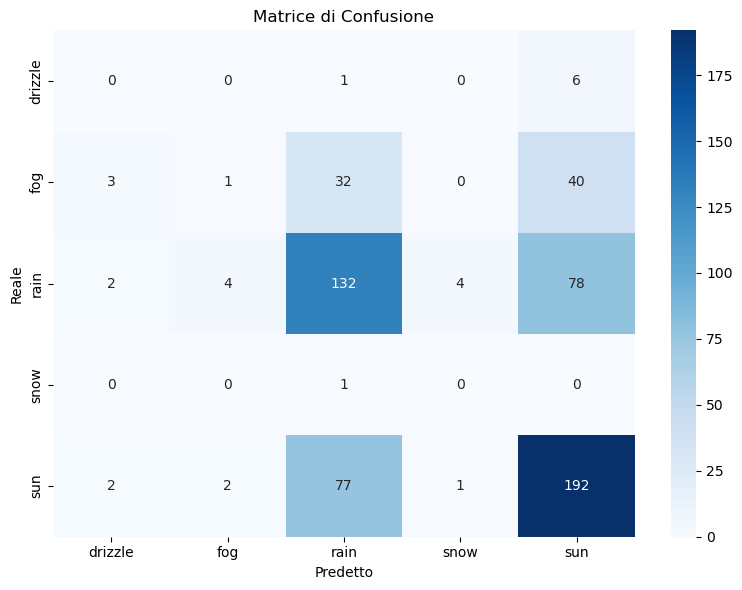

In [160]:
plot_confusion_matrix(y_test.values, xgb_pred)

### Randomized search con XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'max_depth': [3, 5, 7, 10, 12, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

xgb_search = XGBClassifier(objective='multi:softprob', num_class=len(encoder.classes_), eval_metric='mlogloss', random_state=42)
search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=50, scoring='f1_macro', cv=3, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=o

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           class_weight='balanced',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_t...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=200, n_jobs=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10, 12, 15, 20],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='f1_macro', verbose=1)

In [173]:
search_results = pd.DataFrame(search.cv_results_)
print(search_results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.159989      0.035919         0.011252        0.001118   
1        0.302077      0.016517         0.009713        0.000396   
2        0.230076      0.014177         0.011225        0.000776   
3        0.798597      0.068141         0.012341        0.000593   
4        0.787788      0.057567         0.011547        0.001071   
5        0.326224      0.057733         0.011315        0.000570   
6        0.301335      0.019490         0.011559        0.001095   
7        0.119220      0.002728         0.010143        0.001086   
8        0.112170      0.002247         0.009955        0.000125   
9        0.339314      0.032869         0.010504        0.001563   
10       0.881489      0.049187         0.013397        0.000321   
11       0.213937      0.012152         0.010643        0.001043   
12       0.135344      0.006142         0.009611        0.001443   
13       0.398176      0.015218         0.011666

In [174]:
search_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.159989,0.035919,0.011252,0.001118,0.7,100,3,12,0.01,5,0.8,"{'subsample': 0.7, 'n_estimators': 100, 'min_c...",0.286876,0.294537,0.190937,0.257450,0.047136,19
1,0.302077,0.016517,0.009713,0.000396,0.8,300,1,12,0.1,5,1.0,"{'subsample': 0.8, 'n_estimators': 300, 'min_c...",0.267129,0.298107,0.189583,0.251607,0.045644,28
2,0.230076,0.014177,0.011225,0.000776,0.7,200,3,12,0.1,5,0.7,"{'subsample': 0.7, 'n_estimators': 200, 'min_c...",0.266176,0.295169,0.192574,0.251307,0.043184,29
3,0.798597,0.068141,0.012341,0.000593,0.8,300,5,5,0.01,0,1.0,"{'subsample': 0.8, 'n_estimators': 300, 'min_c...",0.319195,0.297448,0.250181,0.288941,0.028810,3
4,0.787788,0.057567,0.011547,0.001071,0.7,300,3,15,0.01,1,0.8,"{'subsample': 0.7, 'n_estimators': 300, 'min_c...",0.294729,0.287413,0.257470,0.279871,0.016119,6


              precision    recall  f1-score   support

         0.0       0.33      0.14      0.20         7
         1.0       0.00      0.00      0.00        76
         2.0       0.60      0.70      0.64       220
         3.0       0.00      0.00      0.00         1
         4.0       0.66      0.76      0.71       274

    accuracy                           0.63       578
   macro avg       0.32      0.32      0.31       578
weighted avg       0.55      0.63      0.58       578



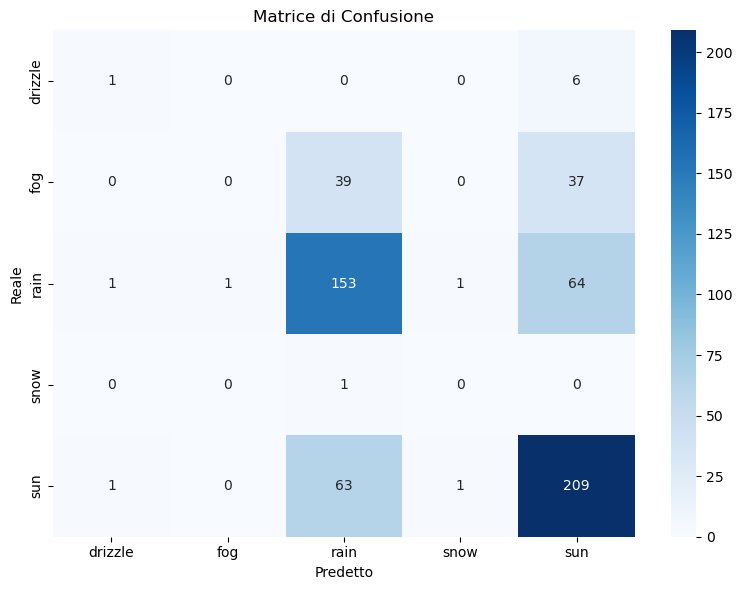

In [171]:
best_xgb = search.best_estimator_
search_pred = best_xgb.predict(X_test)
print(classification_report(y_test, search_pred, zero_division=0))
plot_confusion_matrix(y_test.values, search_pred)

## Logistic regression

## SVM